# Online Convex Optimization

In this notebook, we present the different algorithm implemented in this repository and compare them. Hyperparameters can be tuned globally for all the algorithms at the same time or individually, in each algorithm's own cell. This setup allows quick and easy comparison and can be used to experiment interractively with the different algoritms.

### Imports

In [1]:
import time
import numpy as np
import pandas as pd
import pathlib as Path
import seaborn as sns

In [2]:
from Algorithms.Adam import adamax, adamax_temporal, adam, adam_p, adam_temporal, adam_proj
from Algorithms.Explo import sbeg, sreg
from Algorithms.GD import gd, projected_gd
from Algorithms.SGD import sgd, projected_sgd
from Algorithms.RFTL import adagrad, seg, smd
from Algorithms.ONS import ons
from Models.LinearSVM import LinearSVM
from utils import *

### Default Parameters
The default parameters for the algorithms. It can be particularized later in each specific algorithm block.

In [9]:
np.random.seed(123)

lr = 0.1
nepoch = 100
lbd = 1/3
z = 100
gamma = 1/8
verbose = 100

### Initialization
We start with loading and normalizing the data. We only conduct binary classification so we label images of zeros from MNIST as 1 and every other labels as -1.

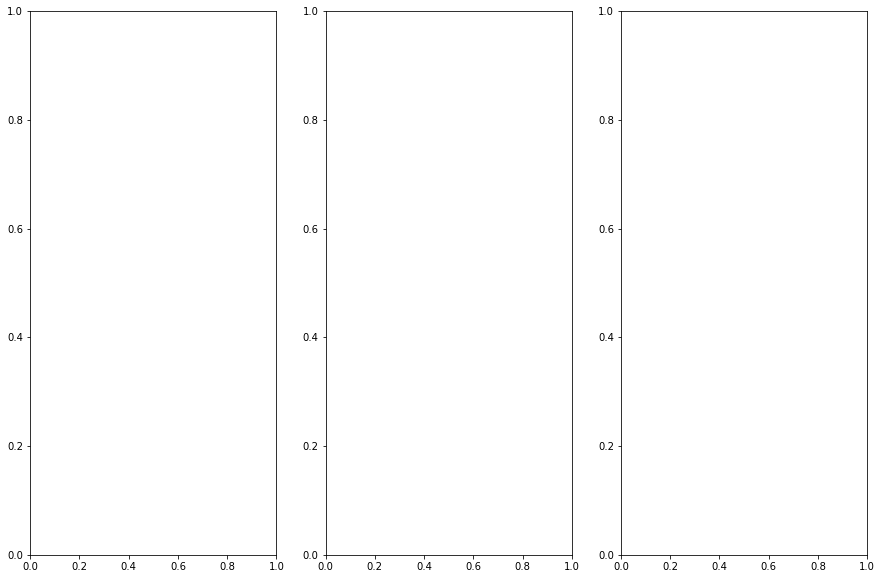

In [10]:
mnist_train = pd.read_csv('mnist_train.csv', sep=',', header=None)   # Reading
# Extract data
train_data = mnist_train.values[:, 1:]
# Normalize data
train_data = train_data / np.max(train_data)
train_data = np.c_[train_data, np.ones(train_data.shape[0])]         # Add intercept
# Extract labels
train_labels = mnist_train.values[:, 0]
# if labels is not 0 => -1 (Convention chosen)
train_labels[np.where(train_labels != 0)] = -1
# if label is 0 ==> 1
train_labels[np.where(train_labels == 0)] = 1

mnist_test = pd.read_csv('mnist_test.csv', sep=',', header=None)
test_data = mnist_test.values[:, 1:]
test_data = test_data / np.max(test_data)
test_data = np.c_[test_data, np.ones(test_data.shape[0])]
test_labels = mnist_test.values[:, 0]
test_labels[np.where(test_labels != 0)] = -1
test_labels[np.where(test_labels == 0)] = 1

time_dict = {}

n, m = train_data.shape
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

### Gradient Descent 

In [12]:
print("-----------GD----------- \n")
model = LinearSVM(m)
tic = time.time()

GDloss, wts = gd(model, train_data, train_labels, nepoch, lbd, verbose, lr)
time_dict['gd'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
GDacc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, Unconstrained GD algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, GDloss[-1], GDacc))

ax[0].plot(np.arange(nepoch), GDloss, label = 'gd')
GDaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(GDaccuracies, label = 'gd')
GDerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(GDerrors, label = 'gd')

-----------GD----------- 

Epoch   0 : Loss = 94.3072
After 100 epoch, Unconstrained GD algorithm has a loss of 40.319478 and accuracy 0.844600


### Constrained Gradient Descend
Gradient Descent with projection on $B_1(z)$

In [13]:
print("-----------c_GD - z="+str(z)+"----------- \n")
model = LinearSVM(m)
tic = time.time()

GDprojloss, wts = projected_gd(model, train_data, train_labels, nepoch, lbd, z, verbose, lr)
time_dict['c_gd z='+str(z)] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
GDacc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained GD (radius {:3d}) algorithm has a losof {:1.6f} and accuracy {:1.6f}'.format(nepoch, z, GDprojloss[-1], GDacc))

ax[0].plot(np.arange(nepoch), GDprojloss, label = 'c_gd z='+str(z))
GDprojaccuracies = compute_accuracies(wts, test_data, test_labels, average=False)  # no average for gd
ax[1].plot(GDprojaccuracies, label = 'c_gd z='+str(z))
GDprojerrors = compute_errors(wts, test_data, test_labels, average=False)
ax[2].plot(GDprojerrors,label = 'c_gd z='+str(z))

-----------c_GD - z=100----------- 

Epoch   0 : Loss = 14.5948
After 100 epoch, constrained GD (radius 100) algorithm has a losof 4.629157 and accuracy 0.944400


### Stochastic Gradient Descent 

In [14]:
print("-----------SGD----------- \n")
model = LinearSVM(m)
tic = time.time()

SGDloss, wts = sgd(model, train_data, train_labels, nepoch, lbd, verbose, lr)
time_dict['sgd'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, Unconstrained SGD algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, SGDloss[-1], acc))

ax[0].plot(np.arange(nepoch), SGDloss, label = 'sgd')
SGDaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(SGDaccuracies, label = 'sgd')
SGDerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(SGDerrors, label = 'sgd')

-----------SGD----------- 

Epoch   0 : Loss = 4.2452
After 100 epoch, Unconstrained SGD algorithm has a loss of 0.228809 and accuracy 0.902000


### Constrained Stochastic Gradient Descent
Stochastic Gradient Descent with projection on $B_1(z)$

In [15]:
print("-----------c_SGD - z=" + str(z)+"----------- \n")
model = LinearSVM(m)
tic = time.time()

SGDprojloss, wts = projected_sgd(model, train_data, train_labels, nepoch, lbd, z, verbose, lr)
time_dict['c_sgd z='+str(z)] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained SGD (radius {:3d}) algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, z, SGDprojloss[-1], acc))

ax[0].plot(np.arange(nepoch), SGDprojloss, label = 'c_sgd z='+str(z))
SGDprojaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(SGDprojaccuracies, label = 'c_sgd z='+str(z))
SGDprojerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(SGDprojerrors, label = 'c_sgd z='+str(z))

-----------c_SGD - z=100----------- 

Epoch   0 : Loss = 2.7497
After 100 epoch, constrained SGD (radius 100) algorithm has a loss of 0.241768 and accuracy 0.902000


### Stochastic Miror Descent (SMD)

In [16]:
model = LinearSVM(m)
tic = time.time()

SMDprojloss, wts = smd(model, train_data, train_labels, nepoch, lbd, z, lr, verbose)
time_dict['smd'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained SMD algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, SMDprojloss[-1], acc))

ax[0].plot(np.arange(nepoch), SMDprojloss, label = 'smd')
SMDprojaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(SMDprojaccuracies, label = 'smd')
SMDprojerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(SMDprojerrors, label = 'smd')

Epoch   0 : Loss = 0.9904
After 100 epoch, constrained SMD algorithm has a loss of 0.561293 and accuracy 0.934900


### Stochastic Exponential Gradient (SEG)

In [17]:
print("-----------SMD----------- \n")
model = LinearSVM(m)
tic = time.time()

SEGloss, wts = seg(model, train_data, train_labels, nepoch, lbd, z, lr, verbose)
time_dict['seg'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained SEG algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, SEGloss[-1], acc))

ax[0].plot(np.arange(nepoch), SEGloss, label = 'seg')
SEGaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(SEGaccuracies, label = 'seg')
SEGerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(SEGerrors, label = 'seg')

-----------SMD----------- 

Epoch   0 : Loss = 1.0097
After 100 epoch, constrained SEG algorithm has a loss of 0.224398 and accuracy 0.902000


### Adaptative Gradient (Adagrad)

In [18]:
print("-----------Adagrad - z=" + str(z)+"----------- \n")
model = LinearSVM(m)
tic = time.time()

Adagradloss, wts = adagrad(model, train_data, train_labels, nepoch, lbd, z, verbose)
time_dict['adagrad'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained Adagrad (radius {:3d}) algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, z, Adagradloss[-1], acc))

ax[0].plot(np.arange(nepoch), Adagradloss, label = 'adagrad z='+str(z))
Adagradaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(Adagradaccuracies, label = 'adagrad z='+str(z))
Adagraderrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(Adagraderrors,  label = 'adagrad z='+str(z))

-----------Adagrad - z=100----------- 

Epoch   0 : Loss = 1.6498
After 100 epoch, constrained Adagrad (radius 100) algorithm has a loss of 0.270706 and accuracy 0.946500


### Online Newton Step (ONS)

In [34]:
print("-----------ONS - z=" + str(z) + "----------- \n")
model = LinearSVM(m)
tic = time.time()

ONSloss, wts = ons(model, train_data, train_labels, nepoch, lbd, gamma, z, 1, verbose)
time_dict['ons'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, ONS (radius {:3d} algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, z, ONSloss[-1], acc))

ax[0].plot(np.arange(nepoch), ONSloss,  label = 'ons z='+str(z))
ONSaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(ONSaccuracies,  label = 'ons z='+str(z))
ONSerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(ONSerrors,  label = 'ons z='+str(z))

-----------ONS - z=100----------- 

Epoch   0 : Loss = 0.6091
After 100 epoch, ONS (radius 100 algorithm has a loss of 0.559055 and accuracy 0.936100


### SREG

In [21]:
print("-----------SREG - z=" + str(z) + "----------- \n")
model = LinearSVM(m)
tic = time.time()

SREGloss, wts = sreg(model, train_data, train_labels, nepoch, lbd, z, lr, verbose)
time_dict['sreg'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained SREG (radius {:3d}) algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, z, SREGloss[-1], acc))

ax[0].plot(np.arange(nepoch), SREGloss, label = 'sreg z='+str(z))
SREGaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(SREGaccuracies, label = 'sreg z='+str(z))
SREGerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(SREGerrors, label = 'sreg z='+str(z))

-----------SREG - z=100----------- 

Epoch   0 : Loss = 1.0219
After 100 epoch, constrained SREG (radius 100) algorithm has a loss of 0.808024 and accuracy 0.896800


### SBEG

In [22]:
print("-----------SBEG - z=" + str(z) + "----------- \n")
model = LinearSVM(m)
tic = time.time()

SBEGloss, wts = sbeg(model, train_data, train_labels, nepoch, lbd, z, lr, verbose)
time_dict['sbeg'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained SBEG algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, SBEGloss[-1], acc))

ax[0].plot(np.arange(nepoch), SBEGloss, label = 'sbeg z='+str(z))
SBEGaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(SBEGaccuracies, label = 'sbeg z='+str(z))
SBEGerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(SBEGerrors, label = 'sbeg z='+str(z))

-----------SBEG - z=100----------- 

Epoch   0 : Loss = 1.0031
After 100 epoch, constrained SBEG algorithm has a loss of 0.869942 and accuracy 0.900900


### Adam

In [23]:
print("-----------Adam - z=" + str(z) + "----------- \n")
model = LinearSVM(m)
tic = time.time()

Adamloss, wts = adam(model, train_data, train_labels, lr, nepoch, lbd, [0.9, 0.999], verbose)
time_dict['adam'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, adam algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, Adamloss[-1], acc))

ax[0].plot(np.arange(nepoch), Adamloss, label = 'adam z='+str(z))
Adamaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(Adamaccuracies, label = 'adam z='+str(z))
Adamerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(Adamerrors, label = 'adam z='+str(z))

-----------Adam - z=100----------- 

Epoch   0 : Loss = 1.0426
After 100 epoch, adam algorithm has a loss of 0.739580 and accuracy 0.917500


### Adam Fixed LR

In [24]:
model = LinearSVM(m)
tic = time.time()

AdamLRloss, wts = adam(model, train_data, train_labels, lr, nepoch, lbd, [0.9, 0.999], verbose, adaptative_lr=False)
time_dict['adam_fixlr'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, adam with fixed lr algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, AdamLRloss[-1], acc))

ax[0].plot(np.arange(nepoch), AdamLRloss, label = 'adam_fixlr')
AdamLRaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(AdamLRaccuracies, label = 'adam_fixlr')
AdamLRerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(AdamLRerrors, label = 'adam_fixlr')

Epoch   0 : Loss = 1.7299
After 100 epoch, adam with fixed lr algorithm has a loss of 1.715588 and accuracy 0.895700


### Adam Projected

In [25]:
model = LinearSVM(m)
tic = time.time()

AdamProjloss, wts = adam_proj(model, train_data, train_labels, lr, nepoch, lbd, z, [0.9, 0.999], verbose)
time_dict['adamproj'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, projected adam algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, AdamProjloss[-1], acc))

ax[0].plot(np.arange(nepoch), AdamProjloss, label = 'adamproj')
AdamProjaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(AdamProjaccuracies, label = 'adamproj')
AdamProjerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(AdamProjerrors, label = 'adamproj')

Epoch   0 : Loss = 1.9056
After 100 epoch, projected adam algorithm has a loss of 2.566865 and accuracy 0.883300


### Adamp

In [26]:
p = 3

model = LinearSVM(m)
tic = time.time()

AdamPloss, wts = adam_p(model, train_data, train_labels, lr, nepoch, lbd, [0.9, 0.999], p, verbose)
time_dict['adamp'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, adam with norm L{:3d} algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, p, AdamPloss[-1], acc))

ax[0].plot(np.arange(nepoch), AdamPloss, label = 'adamp')
AdamPaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(AdamPaccuracies, label = 'adamp')
AdamPerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(AdamPerrors, label = 'adamp')

Epoch   0 : Loss = 1.3060
After 100 epoch, adam with norm L  3 algorithm has a loss of 1.445858 and accuracy 0.902000


### Adam Temp

In [27]:
model = LinearSVM(m)
tic = time.time()

AdamTemploss, wts = adam_temporal(model, train_data, train_labels, lr, nepoch, lbd, [0.9, 0.999], verbose)
time_dict['adamtemp'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, adam with temporal averaging algorithm has a loss of{:1.6f} and accuracy {:1.6f}'.format(nepoch, AdamTemploss[-1], acc))

ax[0].plot(np.arange(nepoch), AdamTemploss, label = 'adamtemp')
AdamTempaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(AdamTempaccuracies, label = 'adamtemp')
AdamTemperrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(AdamTemperrors, label = 'adamtemp')

Epoch   0 : Loss = 1.8121
After 100 epoch, adam with temporal averaging algorithm has a loss of7.170767 and accuracy 0.854600


### Adamax

In [28]:
model = LinearSVM(m)
tic = time.time()

AdaMaxLoss, wts = adamax(model, train_data, train_labels, lr, nepoch, lbd, [0.9, 0.999], verbose)
time_dict['adamax'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, AdaMax algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, AdaMaxLoss[-1], acc))

ax[0].plot(np.arange(nepoch), AdaMaxLoss, label = 'adamax')
AdaMaxaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(AdaMaxaccuracies, label = 'adamax')
AdaMaxerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(AdaMaxerrors, label = 'adamax')

Epoch   0 : Loss = 1.8395
After 100 epoch, AdaMax algorithm has a loss of 0.487985 and accuracy 0.928200


### Adamax Temp

In [29]:
model = LinearSVM(m)
tic = time.time()

AdaMaxTempLoss, wts = adamax_temporal(model, train_data, train_labels, lr, nepoch, lbd, [0.9, 0.999], verbose)
time_dict['adamaxtemp'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, AdaMax with temporal averaging algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, AdaMaxTempLoss[-1], acc))

ax[0].plot(np.arange(nepoch), AdaMaxTempLoss, label = 'adamaxtemp')
AdaMaxTempaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(AdaMaxTempaccuracies, label = 'adamaxtemp')
AdaMaxTemperrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(AdaMaxTemperrors, label = 'adamaxtemp')

Epoch   0 : Loss = 2.6880
After 100 epoch, AdaMax with temporal averaging algorithm has a loss of 0.835770 and accuracy 0.902000


### Curves 

In [35]:
# Log scale
ax[0].set_xscale('log')
ax[0].set_yscale('logit')
ax[1].set_xscale('log')
ax[1].set_yscale('logit')
ax[2].set_xscale('log')
ax[2].set_yscale('logit')

# legend
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[2].set_title('Error')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[2].set_xlabel('Epochs')


plt.savefig('LossAccuraciesErrors.png')
plt.show()

<Figure size 432x288 with 0 Axes>

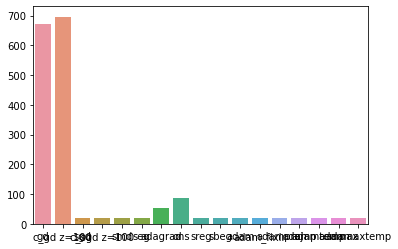

In [31]:
plt.clf()
keys = list(time_dict.keys())
sns.barplot(x=keys, y=[time_dict[k]*20 for k in keys])
plt.savefig('execution_time.png')
plt.show()